[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/langchain-ai/langchain-academy/blob/main/module-4/research-assistant-exercise.ipynb) [![Open in LangChain Academy](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66e9eba12c7b7688aa3dbb5e_LCA-badge-green.svg)](https://academy.langchain.com/courses/take/intro-to-langgraph/lessons/58239974-lesson-4-research-assistant)

# Research Assistant - Exercise Notebook

Welcome to the research assistant exercise notebook! In this interactive session, you'll build your own multi-agent research system using LangGraph.

## Learning Objectives

By the end of these exercises, you will be able to:

1. **Design Multi-Agent Systems**: Create analyst personas with specific roles and expertise areas
2. **Implement Human-in-the-Loop**: Build interactive workflows where humans can provide feedback and refine AI-generated content
3. **Build Interview Workflows**: Create conversational agents that conduct structured interviews with experts
4. **Use Parallel Processing**: Leverage LangGraph's `Send()` API for map-reduce patterns
5. **Integrate Multiple Data Sources**: Combine web search, Wikipedia, and other sources for comprehensive research
6. **Create Report Generation Pipelines**: Transform raw research into structured, professional reports

## Exercise Structure

This notebook contains **5 progressive exercises**:

- **Exercise 1**: Basic Analyst Generation (Beginner)
- **Exercise 2**: Human Feedback Loop (Intermediate) 
- **Exercise 3**: Expert Interview System (Intermediate)
- **Exercise 4**: Multi-Source Research Integration (Advanced)
- **Exercise 5**: Complete Research Assistant Pipeline (Advanced)

Each exercise builds upon the previous one, gradually increasing in complexity.

---

## Setup

Let's start by installing the required packages and setting up our environment.

In [1]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENAI_API_KEY")
_set_env("LANGSMITH_API_KEY")
_set_env("TAVILY_API_KEY")

# Set up tracing
os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_PROJECT"] = "langchain-academy"

In [2]:
from langchain_openai import ChatOpenAI
from IPython.display import Image, display, Markdown
import operator
from typing import List, Annotated, Literal
from typing_extensions import TypedDict
from pydantic import BaseModel, Field
from langgraph.graph import START, END, StateGraph, MessagesState
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage

# Initialize LLM
llm = ChatOpenAI(model="gpt-5-mini", reasoning={'effort':'minimal'})

---

# Exercise 1: Basic Analyst Generation (Beginner)

## Objective
Create a system that generates AI analyst personas for a given research topic.

## Background
The foundation of a good research assistant is having diverse perspectives. Different analysts bring unique viewpoints, expertise areas, and concerns to research topics.

## Your Task

1. **Define Data Models**: Create Pydantic models for `Analyst` and `Perspectives`
2. **Create State Schema**: Define a TypedDict for managing analyst generation state
3. **Implement Analyst Generator**: Write a function that uses structured LLM output to create analysts
4. **Test Your Implementation**: Generate analysts for a sample topic

### Step 1: Define the Analyst Model

Complete the `Analyst` class below. Each analyst should have:
- `name`: The analyst's name
- `affiliation`: Their organization or company
- `role`: Their job title or role
- `description`: A detailed description of their focus and expertise
- `persona` property: A formatted string combining all analyst information

In [42]:
class Analyst(BaseModel):
    # TODO: Add fields for affiliation, name, role, and description
    name: str = Field(description='analyst name')
    affiliation: str = Field(description='organization of company')
    role: str = Field(description='job title or role')
    description: str = Field(description='a detailed description of their foucs and expertise')
    @property
    def persona(self) -> str:
        return f"Name: {self.name}\nRole: {self.role}\nAffiliation: {self.affiliation}\nDescription: {self.description}\n"

class Perspectives(BaseModel):
    # TODO: Add a field for a list of analysts
    analysts: List[Analyst] = Field(description="Comprehensive list of analysts with their roles and affiliations.",)

### Step 2: Create State Schema

Define a TypedDict for managing the analyst generation process:

In [4]:
class AnalystGenerationState(TypedDict):
    # TODO: Add fields for:
    # - topic: str (the research topic)
    # - max_analysts: int (maximum number of analysts to generate)
    # - analysts: List[Analyst] (the generated analysts)
    topic: str
    max_analysts: int
    analysts: List[Analyst]

### Step 3: Implement Analyst Generator

Create a function that generates analysts based on a topic:

In [5]:
analyst_instructions = """You are tasked with creating a set of AI analyst personas. Follow these instructions carefully:

1. First, review the research topic: {topic}
        
2. Determine the most interesting themes and perspectives for this topic.
                    
3. Pick the top {max_analysts} themes.

4. Assign one analyst to each theme, ensuring diversity in:
   - Professional backgrounds
   - Industry affiliations
   - Areas of expertise
   - Potential concerns or interests

5. Make each analyst realistic and specific to their domain."""

def create_analysts(state: AnalystGenerationState):
   """ Create analysts based on topic and max count """
    
   # TODO: Extract topic and max_analysts from state
   topic = state['topic']
   max_analysts = state['max_analysts']

   
   # TODO: Create a structured LLM that outputs Perspectives
   # Use: llm.with_structured_output(Perspectives)
   structured_llm = llm.with_structured_output(Perspectives)
    
   # TODO: Format the system message with topic and max_analysts
   system_prompt = analyst_instructions.format(topic=topic, max_analysts=max_analysts)

   # TODO: Invoke the structured LLM with system message and human message
   analysts = structured_llm.invoke([SystemMessage(content=system_prompt)]+[HumanMessage(content='Generate a list of analysts')])
   
   
   # TODO: Return the analysts in the correct state format
   return {'analysts': analysts.analysts}

create_analysts({'topic':'Compare langgraph and pydantic AI', 'max_analysts':3})

{'analysts': [Analyst(name='Dr. Mira Patel', affiliation='AI Foundations Lab, University of Cambridge', role='Research Scientist — Machine Learning & Formal Methods', description='Focuses on theory and guarantees for AI systems, including formal verification, type systems, and model interpretability. Mira evaluates tooling for correctness, robust schema enforcement, and how libraries affect system reliability and provable properties. Concerned with how langgraph and pydantic surface invariants, type safety, and integration with formal verification workflows. Has published on typed DSLs for ML pipelines and on bridging probabilistic models with deterministic schema checks.', persona='Dr. Mira Patel — Research Scientist at AI Foundations Lab, University of Cambridge. Expert in formal methods, type systems, and ML pipeline correctness; evaluates langgraph and pydantic for guarantees, schema enforcement, and integration with verification workflows.'),
  Analyst(name='Carlos Rivera', affili

### Step 4: Test Your Implementation

Create a simple graph and test your analyst generation:

In [6]:
# TODO: Create a StateGraph with AnalystGenerationState
# Add the create_analysts node
# Connect START -> create_analysts -> END
# Compile the graph

builder = StateGraph(AnalystGenerationState)
builder.add_node('create_analysts', create_analysts)
builder.add_edge(START, 'create_analysts')
builder.add_edge('create_analysts', END)
graph = builder.compile()
# Test with this topic:
test_topic = "The impact of artificial intelligence on healthcare diagnostics"
max_analysts = 3

# Run the graph and print results
result = graph.invoke({"topic": test_topic, "max_analysts": max_analysts})
for analyst in result['analysts']:
    print(f"Name: {analyst.name}")
    print(f"Affiliation: {analyst.affiliation}")
    print(f"Role: {analyst.role}")
    print(f"Description: {analyst.description}")
    print("-" * 50)

Name: Dr. Aisha Rahman
Affiliation: Massachusetts General Hospital / Harvard Medical School
Role: Clinical AI Research Lead, Diagnostic Radiology
Description: Radiologist and physician-scientist focused on integrating machine learning into medical imaging workflows. Leads clinical trials evaluating AI tools for chest X-ray, CT, and MRI interpretation, with expertise in model validation, prospective trial design, and regulatory requirements for diagnostic devices. Interests include improving diagnostic sensitivity and reducing time-to-diagnosis while maintaining clinician oversight. Concerns center on algorithmic bias across demographic groups, clinical workflow disruption, and liability/credentialing for AI-augmented decisions.
--------------------------------------------------
Name: Miguel Santos
Affiliation: MedTech Start-up: VeridX Health
Role: Chief Product Officer, AI Diagnostics
Description: Product leader with a background in biomedical engineering and startup scaling. Oversees 

### 🎯 **Checkpoint 1**: Verify Your Solution

Your analyst generator should:
- ✅ Create exactly the requested number of analysts
- ✅ Generate diverse perspectives relevant to the topic
- ✅ Include realistic names, affiliations, and roles
- ✅ Provide detailed descriptions of each analyst's focus

---

# Exercise 2: Human Feedback Loop (Intermediate)

## Objective
Extend your analyst generation system to include human-in-the-loop feedback for refining analyst selection.

## Background
Real-world research assistants need human oversight. Users should be able to review generated analysts and provide feedback to improve the selection before proceeding with research.

## Your Task

1. **Extend State Schema**: Add human feedback capability
2. **Create Feedback Node**: Implement a human feedback interruption point
3. **Add Conditional Logic**: Route based on feedback presence
4. **Test Interactive Flow**: Experience the human-in-the-loop workflow

### Step 1: Extend State Schema

Update your state to include human feedback:

In [7]:
class EnhancedAnalystState(TypedDict):
    topic: str
    max_analysts: int
    analysts: List[Analyst]
    # TODO: Add human_analyst_feedback: str field
    human_analyst_feedback: str  

### Step 2: Update Analyst Creation Function

Modify your analyst creation to consider human feedback:

In [8]:
enhanced_analyst_instructions = """You are tasked with creating a set of AI analyst personas. Follow these instructions carefully:

1. First, review the research topic: {topic}
        
2. Examine any editorial feedback that has been provided to guide creation of the analysts: 
{human_analyst_feedback}
    
3. Determine the most interesting themes based upon the topic and feedback above.
                    
4. Pick the top {max_analysts} themes.

5. Assign one analyst to each theme, incorporating any specific feedback provided."""

def create_analysts_with_feedback(state: EnhancedAnalystState):
    """ Create analysts, considering human feedback if provided """
    
    topic = state['topic']
    max_analysts = state['max_analysts']
    # TODO: Get human_analyst_feedback from state, default to empty string if not present
    human_analyst_feedback = state.get('human_analyst_feedback','')
    
    # TODO: Create structured LLM
    llm_with_struct = llm.with_structured_output(Perspectives)
    
    # TODO: Format system message with topic, feedback, and max_analysts
    
    system_prompt = enhanced_analyst_instructions.format(topic=topic, human_analyst_feedback=human_analyst_feedback,
                                                         max_analysts=max_analysts)
    # print(system_prompt)
    
    # TODO: Generate analysts and return in state format
    result = llm_with_struct.invoke([SystemMessage(content=system_prompt)]+[HumanMessage(content='Generate a list of analysts')])

    return {'analysts':result.analysts}

### Step 3: Create Human Feedback Components

Implement the feedback node and routing logic:

In [9]:
def human_feedback(state: EnhancedAnalystState):
    """ No-op node that should be interrupted on """
    # TODO: This should be a pass-through node
    # The interruption happens in the graph compilation
    pass

def should_continue(state: EnhancedAnalystState) -> Literal['create_analysts', END]:
    """ Determine next node based on feedback presence """
    
    # TODO: Check if human_analyst_feedback exists and is not None/empty
    # If feedback exists, return "create_analysts" to regenerate
    # Otherwise, return END
    # if there is human feedback, then recreate the analysts
    if state.get('human_analyst_feedback',None):
        return 'create_analysts'
    else:
        return END

### Step 4: Build Interactive Graph

Create a graph with human-in-the-loop functionality:

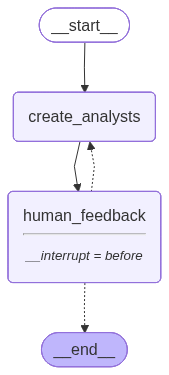

In [31]:
# TODO: Create StateGraph with EnhancedAnalystState
# Add nodes: create_analysts_with_feedback, human_feedback
# Add edges: START -> create_analysts_with_feedback -> human_feedback
# Add conditional edge: human_feedback -> should_continue -> ["create_analysts_with_feedback", END]
# Compile with interrupt_before=['human_feedback'] and MemorySaver checkpointer

builder = StateGraph(EnhancedAnalystState)
builder.add_node('create_analysts', create_analysts_with_feedback)
builder.add_node('human_feedback', human_feedback)
builder.add_edge(START, 'create_analysts')

builder.add_edge('create_analysts', 'human_feedback')
builder.add_conditional_edges('human_feedback', should_continue)


memory = MemorySaver()
graph = builder.compile(interrupt_before=['human_feedback'], checkpointer=memory)

# Display the graph
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))


### Step 5: Test Interactive Flow

Experience the human feedback workflow:

In [11]:
# TODO: Set up initial parameters
topic = "The future of renewable energy storage technologies"
max_analysts = 3
thread = {"configurable": {"thread_id": "1"}}

# TODO: Run until first interruption
# Use graph.stream() with stream_mode="values"
# Print analysts when they appear in events
# steam will return the graph state
# thread is a required argument for .stream()

for cur_state in graph.stream({'topic': topic, 'max_analysts':max_analysts}, thread, stream_mode='values'):
    analysts = cur_state.get('analysts','')
    if analysts:
        print("Generated Analysts:")
        for analyst in analysts:
            print(f"- {analyst.name}, {analyst.affiliation}, {analyst.role}")
        print("-" * 50)
        
        
    
print("Initial analysts generated. Waiting for human feedback...")

Generated Analysts:
- Dr. Aisha Raman, Global Renewable Futures Institute, Senior Energy Storage Researcher
- Miguel Torres, Urban Clean Grid Labs, Distributed Energy Systems Architect
- Prof. Elena Kovács, European Centre for Materials & Energy, Materials Scientist & Storage Innovation Lead
--------------------------------------------------
Initial analysts generated. Waiting for human feedback...


In [12]:
# TODO: Provide feedback using graph.update_state()
# Example feedback: "Add a policy analyst focused on government regulations and incentives"
# Use as_node="human_feedback"

feedback = "Add a policy analyst focused on government regulations and incentives"
graph.update_state(thread, {"human_analyst_feedback": feedback}, as_node="human_feedback")

print(f"Feedback provided: {feedback}")

Feedback provided: Add a policy analyst focused on government regulations and incentives


In [13]:
# TODO: Continue execution after feedback
# Use graph.stream(None, thread, stream_mode="values")
# Print the updated analysts
# values will return the full state
# update will return a dict of node name and output

for cur_state in graph.stream(None, thread, stream_mode='updates'):
    print(cur_state)

print("Updated analysts after feedback:")

# get state will return the latest statesnapshot
state = graph.get_state(thread) 
analysts = state.values.get('analysts','')
if analysts:
    print("Generated Analysts:")
    for analyst in analysts:
        print(f"- {analyst.name}, {analyst.affiliation}, {analyst.role}")
    print("-" * 50)

graph.update_state(thread, {'human_analyst_feedback':None}, as_node='human_feedback')

# run till the end
for event in graph.stream(None, thread, stream_mode="updates"):
    print(event.keys())

{'create_analysts': {'analysts': [Analyst(name='Dr. Maya R. Singh', affiliation='Global Energy Systems Lab', role='Storage Technology Research Lead', description='Focuses on advanced chemical and electrochemical storage solutions, including next-generation batteries (solid-state, flow, metal-air) and hydrogen carriers. Research spans materials discovery, cell architecture, lifecycle performance, cost projections, and grid integration challenges. Advises on scaling lab discoveries to manufacturable products and assesses long-term durability, supply chain constraints for critical minerals, and recycling pathways.', persona='Dr. Maya R. Singh — Storage Technology Research Lead at Global Energy Systems Lab. An expert on advanced batteries, hydrogen carriers, materials innovation, and the path from lab-scale breakthroughs to scalable, durable, and recyclable commercial storage systems.'), Analyst(name="Liam O'Connor", affiliation='Institute for Grid Innovation', role='Systems Integration an

### 🎯 **Checkpoint 2**: Verify Your Solution

Your interactive system should:
- ✅ Generate initial analysts and pause for feedback
- ✅ Accept human feedback and regenerate analysts accordingly
- ✅ Allow multiple rounds of feedback if needed
- ✅ Proceed to completion when no feedback is provided

---

# Exercise 3: Expert Interview System (Intermediate)

## Objective
Build an interview system where AI analysts conduct multi-turn conversations with AI experts to gather insights.

## Background
The heart of the research assistant is conducting thorough interviews. Analysts ask questions, experts search for information and provide answers, and the conversation continues until sufficient insights are gathered.

## Your Task

1. **Design Interview State**: Create state schema for managing conversations
2. **Build Question Generator**: Implement analyst question generation
3. **Create Search Functions**: Add web and Wikipedia search capabilities
4. **Implement Answer Generator**: Create expert response system
5. **Add Conversation Control**: Manage interview flow and termination

### Step 1: Define Interview State

Create a state schema for managing interviews:

In [ ]:
class InterviewState(MessagesState):
    # TODO: Add the following fields:
    # - max_num_turns: int (maximum conversation turns)
    # - context: Annotated[list, operator.add] (source documents)
    # - analyst: Analyst (the analyst conducting interview)
    # - interview: str (final interview transcript)
    # pass
    max_num_turns: int 
    context: Annotated[list, operator.add]
    analyst: Analyst
    interview: str

class SearchQuery(BaseModel):
    # TODO: Add search_query field with appropriate description
    search_query: str = Field(description='Search query for gathering more information')

### Step 2: Implement Question Generation

Create a function for analysts to generate interview questions:

In [22]:
question_instructions = """You are an analyst tasked with interviewing an expert to learn about a specific topic. 

Your goal is to gather interesting and specific insights related to your area of expertise.

1. Interesting: Insights that people will find surprising or non-obvious.
2. Specific: Insights that avoid generalities and include specific examples.

Here is your area of focus: {goals}
        
Begin by introducing yourself using your name, and then ask your question.

Continue to ask follow-up questions to drill down and refine your understanding.
        
When you are satisfied with your understanding, complete the interview with: "Thank you so much for your help!"

Stay in character throughout your response."""

def generate_question(state: InterviewState):
    """ Generate analyst question """
    
    # TODO: Extract analyst and messages from state
    analyst = state['analyst']
    messages = state['messages']
    
    # TODO: Create system message using question_instructions template
    # Format with analyst.persona as goals
    system_prompt = question_instructions.format(goals=analyst.persona)
    
    # TODO: Invoke LLM with system message + existing messages
    questions = llm.invoke([SystemMessage(content=system_prompt)]+messages)
    
    # TODO: Return new message in messages list
    return {'messages': [questions]}

### Step 3: Create Search Functions

Implement web and Wikipedia search capabilities:

In [23]:
# Set up search tools
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_community.document_loaders import WikipediaLoader

tavily_search = TavilySearchResults(max_results=3)

# Search query instructions
search_instructions = SystemMessage(content="""You will be given a conversation between an analyst and an expert. 

Your goal is to generate a well-structured query for retrieval and web search.
        
Analyze the full conversation and pay particular attention to the final question posed by the analyst.

Convert this final question into a well-structured web search query.""")

def search_web(state: InterviewState):
    """ Search web for relevant information """
    
    # TODO: Create structured LLM for SearchQuery
    llm_search = llm.with_structured_output(SearchQuery)
    
    # TODO: Generate search query from conversation messages
    queries = llm_search.invoke([search_instructions]+state['messages'])
    
    # TODO: Use tavily_search.invoke() to get search results
    search_doc = tavily_search.invoke(queries.search_query)
    # TODO: Format search results as documents with <Document> tags
    # Format: '<Document href="{url}"/>\n{content}\n</Document>'

    formatted_search_docs = '\n\n---\n\n'.join([
        f'<Document href="{doc['url']}"/>\n{doc['content']}\n</Document>' for doc in search_doc
    ])
    
    # TODO: Return formatted docs in context list
    return {'context': [formatted_search_docs]}

def search_wikipedia(state: InterviewState):
    """ Search Wikipedia for relevant information """
    
    # TODO: Similar to search_web but use WikipediaLoader
    # Load max 2 documents
    # Format with source and page metadata
    llm_search = llm.with_structured_output(SearchQuery)
    queries = llm_search.invoke([search_instructions]+state['messages'])

    search_docs = WikipediaLoader(queries.search_query, load_max_docs=2).load()

    # Format
    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document source="{doc.metadata["source"]}" page="{doc.metadata.get("page", "")}"/>\n{doc.page_content}\n</Document>'
            for doc in search_docs
        ]
    )

    return {'context': [formatted_search_docs]}

### Step 4: Implement Answer Generation

Create the expert response system:

In [24]:
answer_instructions = """You are an expert being interviewed by an analyst.

Here is the analyst's area of focus: {goals}
        
Your goal is to answer the question posed by the interviewer using this context:
        
{context}

Guidelines:
        
1. Use only information provided in the context.
2. Do not introduce external information beyond what is in the context.
3. Include source citations using [1], [2], etc.
4. List sources at the end of your answer.
5. Be specific and provide concrete examples when available."""

def generate_answer(state: InterviewState):
    """ Generate expert answer using search context """
    
    # TODO: Extract analyst, messages, and context from state
    analyst = state['analyst']
    messages = state['messages']
    context = state['context']
    
    # TODO: Format system message with analyst goals and context
    system_prompt = answer_instructions.format(goals=analyst.persona, context=context)
    
    # TODO: Generate answer using LLM
    answer = llm.invoke([SystemMessage(content=system_prompt)]+[HumanMessage(content='Answer the question.')])
    
    # TODO: Set answer.name = "expert"
    answer.name = 'expert'
    
    # TODO: Return answer in messages list
    return {'messages': [answer]}

### Step 5: Add Interview Control

Implement conversation flow management:

In [28]:
from langchain_core.messages import get_buffer_string

def route_conversation(state: InterviewState) -> Literal['end_interview', 'continue_questions']:
    """ Route between continuing questions or ending interview """
    
    messages = state["messages"]
    max_num_turns = state.get('max_num_turns', 3)

    # TODO: Count expert responses (messages with name="expert")
    num_expert_response = len([m for m in messages if m.name =='expert'])
    
    # TODO: If expert responses >= max_num_turns, return 'end_interview'
    if num_expert_response >= max_num_turns:
        return 'end_interview'
    
    # TODO: Check if last question contains "Thank you so much for your help"
    # If yes, return 'end_interview'
    if 'Thank you so much for your help' in messages[-1].content:
        return 'end_interview'
    
    # TODO: Otherwise return 'continue_questions'
    return 'continue_questions'

def save_interview(state: InterviewState):
    """ Convert interview to string format """
    
    # TODO: Get messages from state
    messages = state['messages']
    
    # TODO: Use get_buffer_string() to convert to text
    interview = get_buffer_string(messages)
    
    # TODO: Return as interview field
    return {'interview': interview}

### Step 6: Build Interview Graph

Assemble your interview system:

In [44]:
# TODO: Create StateGraph with InterviewState
# Add nodes: generate_question, search_web, search_wikipedia, generate_answer, save_interview
builder = StateGraph(InterviewState)
builder.add_node('generate_question', generate_question)
builder.add_node('search_web', search_web)
builder.add_node('search_wikipedia', search_wikipedia)
builder.add_node('generate_answer', generate_answer)
builder.add_node('save_interview', save_interview)

# TODO: Add edges:
# START -> generate_question
# generate_question -> search_web (parallel)
# generate_question -> search_wikipedia (parallel)
# Both searches -> generate_answer
# generate_answer -> route_conversation (conditional)
# route: continue_questions -> generate_question, end_interview -> save_interview
# save_interview -> END
builder.add_edge(START, 'generate_question')
builder.add_edge('generate_question', 'search_wikipedia')
builder.add_edge('generate_question', 'search_web')
builder.add_edge('search_web', 'generate_answer')
builder.add_edge('search_wikipedia', 'generate_answer')
builder.add_conditional_edges('generate_answer', route_conversation, 
                              {'continue_questions': 'generate_question', 'end_interview':'save_interview'})


# TODO: Compile with MemorySaver
memory = MemorySaver()
interview_graph = builder.compile(memory)

# Display graph

# display(Image(interview_graph.get_graph(xray=1).draw_mermaid_png()))

# interview_graph.get_graph()

# display(Image(interview_graph.get_graph().draw_mermaid_png()))

### Step 7: Test Interview System

Run a sample interview:

In [ ]:
# Create a test analyst
test_analyst = Analyst(
    name="Dr. Sarah Chen",
    affiliation="Climate Technology Institute",
    role="Sustainability Researcher",
    description="Focuses on renewable energy adoption barriers and policy solutions"
)

# TODO: Set up initial interview state
topic = "barriers to renewable energy adoption"
initial_message = HumanMessage(content=f"I understand you're researching {topic}?")
thread = {"configurable": {"thread_id": "interview_test"}}

# TODO: Run interview and display results
result = interview_graph.invoke({
    "analyst": test_analyst,
    "messages": [initial_message],
    "max_num_turns": 2,
    "context": [],
    "interview": ""
}, thread)

# print("Interview completed!")
# print("\nInterview transcript:")
print(result.get('interview', 'No interview saved'))

TypeError: string indices must be integers, not 'str'

### 🎯 **Checkpoint 3**: Verify Your Solution

Your interview system should:
- ✅ Generate contextual questions based on analyst persona
- ✅ Search multiple sources (web + Wikipedia) in parallel
- ✅ Provide well-sourced expert answers
- ✅ Control conversation flow based on turn limits or completion phrases
- ✅ Save complete interview transcripts

---

# Exercise 4: Multi-Source Research Integration (Advanced)

## Objective
Enhance the interview system with section writing capabilities and integrate multiple research sources.

## Background
Raw interview transcripts need to be transformed into polished research sections. This exercise focuses on processing interview results and generating structured reports with proper citations.

## Your Task

1. **Extend Interview State**: Add section writing capability
2. **Create Section Writer**: Transform interviews into report sections
3. **Add Custom Data Sources**: Integrate additional research sources
4. **Test Enhanced Pipeline**: Run complete interview-to-section workflow

### Step 1: Enhanced Interview State

Extend the interview state to support section generation:

In [ ]:
class EnhancedInterviewState(MessagesState):
    max_num_turns: int
    context: Annotated[list, operator.add]
    analyst: Analyst
    interview: str
    # TODO: Add sections field as list for report sections
    # pass

### Step 2: Implement Section Writer

Create a function to transform interviews into structured sections:

In [ ]:
section_writer_instructions = """You are an expert technical writer. 
            
Your task is to create a short, digestible section of a report based on source documents.

1. Analyze the content of the source documents:
- Document names are at the start with <Document> tags
        
2. Create a report structure using markdown:
- Use ## for section title
- Use ### for sub-section headers
        
3. Write the report with this structure:
a. Title (## header)
b. Summary (### header)  
c. Sources (### header)

4. Make your title engaging based on the analyst focus: {focus}

5. For the summary section:
- Provide background context related to the analyst's focus area
- Emphasize novel, interesting, or surprising insights
- Use numbered citations [1], [2], etc.
- Target approximately 400 words maximum
- Do not mention interviewer or expert names
        
6. In the Sources section:
- List all sources used with full links/paths
- Use newlines between sources
- Combine duplicate sources

### Sources
[1] Source name or link
[2] Source name or link
"""

def write_section(state: EnhancedInterviewState):
    """ Transform interview and context into structured section """
    
    # TODO: Extract interview, context, and analyst from state
    
    # TODO: Format system message with analyst description as focus
    
    # TODO: Create human message with context as source material
    
    # TODO: Invoke LLM to generate section
    
    # TODO: Return section content in sections list
    pass

### Step 3: Add Custom Data Sources

Create additional search capabilities for more diverse sources:

In [ ]:
def search_academic_papers(state: EnhancedInterviewState):
    """ Simulate academic paper search (placeholder implementation) """
    
    # TODO: For this exercise, create a mock academic source
    # In a real implementation, you might use arXiv API, Semantic Scholar, etc.
    
    structured_llm = llm.with_structured_output(SearchQuery)
    search_query = structured_llm.invoke([search_instructions] + state['messages'])
    
    # Mock academic content based on search query
    mock_academic_content = f"""<Document source="academic_db" paper="{search_query.search_query.replace(' ', '_')}_2024.pdf"/>
Academic research findings related to {search_query.search_query}. This paper presents evidence-based insights 
and methodological approaches relevant to the research question. Key findings include statistical analysis, 
experimental results, and peer-reviewed conclusions that support the theoretical framework.
</Document>"""
    
    return {"context": [mock_academic_content]}

def search_industry_reports(state: EnhancedInterviewState):
    """ Simulate industry report search """
    
    # TODO: Create mock industry report content
    # Similar structure to academic search but with industry focus
    pass

### Step 4: Build Enhanced Interview Graph

Create an interview system with section writing:

In [ ]:
# TODO: Create StateGraph with EnhancedInterviewState
# Add all previous nodes plus:
# - search_academic_papers
# - search_industry_reports  
# - write_section

# TODO: Update edges to include new search sources in parallel
# Add: save_interview -> write_section -> END

# TODO: Compile and display
# enhanced_interview_graph = ...
# display(Image(enhanced_interview_graph.get_graph().draw_mermaid_png()))

### Step 5: Test Enhanced System

Run a complete interview with section generation:

In [ ]:
# Create a test analyst focused on a specific domain
tech_analyst = Analyst(
    name="Alex Rodriguez",
    affiliation="Future Tech Ventures",
    role="Technology Investment Analyst",
    description="Evaluates emerging technologies for investment potential, focusing on market viability, technical feasibility, and competitive advantages"
)

# TODO: Run enhanced interview system
topic = "quantum computing commercialization prospects"
# result = enhanced_interview_graph.invoke({
#     "analyst": tech_analyst,
#     "messages": [HumanMessage(content=f"I'd like to discuss {topic}")],
#     "max_num_turns": 2
# })

# TODO: Display the generated section
# if 'sections' in result and result['sections']:
#     display(Markdown(result['sections'][0]))
# else:
#     print("No section generated")

### 🎯 **Checkpoint 4**: Verify Your Solution

Your enhanced interview system should:
- ✅ Generate structured report sections with proper markdown formatting
- ✅ Include citations and source references
- ✅ Integrate multiple data sources (web, Wikipedia, academic, industry)
- ✅ Transform conversational interviews into professional report content
- ✅ Handle diverse analyst perspectives and focus areas

---

# Exercise 5: Complete Research Assistant Pipeline (Advanced)

## Objective
Build the full research assistant system that generates analysts, conducts parallel interviews, and produces comprehensive research reports.

## Background
This is the capstone exercise where you'll combine all previous components into a sophisticated research assistant using LangGraph's `Send()` API for parallel processing and map-reduce patterns.

## Your Task

1. **Design Complete State Schema**: Create comprehensive state for the full pipeline
2. **Implement Map-Reduce Pattern**: Use Send() API for parallel interviews
3. **Create Report Generation**: Build introduction, content, and conclusion writers
4. **Assemble Final Pipeline**: Connect all components with proper flow control
5. **Test Complete System**: Run end-to-end research assistant workflow

### Step 1: Complete State Schema

Design the master state for the research assistant:

In [ ]:
from langgraph.constants import Send

class ResearchAssistantState(TypedDict):
    # TODO: Add fields for complete research pipeline:
    # - topic: str (research topic)
    # - max_analysts: int (number of analysts)
    # - human_analyst_feedback: str (human feedback)
    # - analysts: List[Analyst] (generated analysts)
    # - sections: Annotated[list, operator.add] (report sections from interviews)
    # - introduction: str (report introduction)
    # - content: str (main report content)
    # - conclusion: str (report conclusion)
    # - final_report: str (complete assembled report)
    pass

### Step 2: Implement Interview Orchestration

Create the map function that launches parallel interviews:

In [ ]:
def initiate_all_interviews(state: ResearchAssistantState):
    """ Launch parallel interviews using Send() API """
    
    # TODO: Check if human feedback exists
    # If yes, return "create_analysts" to regenerate
    
    # TODO: Otherwise, create Send() messages for each analyst
    # Each Send should target "conduct_interview" with:
    # - analyst: the specific analyst
    # - messages: initial HumanMessage about the topic
    
    # Example structure:
    # return [Send("conduct_interview", {
    #     "analyst": analyst,
    #     "messages": [HumanMessage(content=f"I'd like to discuss {topic}")],
    #     "max_num_turns": 2
    # }) for analyst in state["analysts"]]
    pass

### Step 3: Create Report Writers

Implement functions to generate different parts of the final report:

In [ ]:
report_writer_instructions = """You are a technical writer creating a report on: {topic}
    
You have a team of analysts who each:
1. Conducted expert interviews on specific sub-topics
2. Wrote findings into memos

Your task:
1. Analyze the collection of memos from your analysts
2. Consolidate insights into a cohesive narrative
3. Tie together central ideas from all memos

Format requirements:
1. Use markdown formatting
2. No preamble
3. No sub-headings
4. Start with: ## Insights
5. Preserve citations [1], [2], etc.
6. Create consolidated Sources section: ## Sources
7. Don't mention analyst names

Here are the analyst memos: {context}"""

def write_report(state: ResearchAssistantState):
    """ Consolidate all sections into main report content """
    
    # TODO: Extract sections and topic from state
    
    # TODO: Join all sections with newlines
    
    # TODO: Format system message with topic and combined sections
    
    # TODO: Generate consolidated report content
    
    # TODO: Return in content field
    pass

intro_conclusion_instructions = """You are a technical writer finishing a report on {topic}

You will be given all sections of the report.

Write a crisp and compelling {section_type} section.

Guidelines:
- No preamble
- Target ~100 words
- Use markdown formatting
- For introduction: compelling title with # header, then ## Introduction
- For conclusion: ## Conclusion header
- Preview (intro) or recap (conclusion) all report sections

Report sections: {formatted_str_sections}"""

def write_introduction(state: ResearchAssistantState):
    """ Generate report introduction """
    
    # TODO: Extract sections and topic
    # TODO: Join sections and format instructions
    # TODO: Generate introduction
    # TODO: Return in introduction field
    pass

def write_conclusion(state: ResearchAssistantState):
    """ Generate report conclusion """
    
    # TODO: Similar to write_introduction but for conclusion
    pass

def finalize_report(state: ResearchAssistantState):
    """ Assemble complete final report """
    
    # TODO: Extract introduction, content, and conclusion
    
    # TODO: Clean up content format (remove "## Insights" prefix if present)
    
    # TODO: Handle sources section separation if needed
    
    # TODO: Assemble: introduction + "\n\n---\n\n" + content + "\n\n---\n\n" + conclusion
    
    # TODO: Add sources section if extracted
    
    # TODO: Return in final_report field
    pass

### Step 4: Assemble Master Graph

Connect all components into the complete research assistant:

In [ ]:
# TODO: Create StateGraph with ResearchAssistantState
# Add nodes:
# - create_analysts_with_feedback (from Exercise 2)
# - human_feedback
# - conduct_interview (use enhanced_interview_graph from Exercise 4)
# - write_report
# - write_introduction  
# - write_conclusion
# - finalize_report

# TODO: Add edges:
# START -> create_analysts_with_feedback
# create_analysts_with_feedback -> human_feedback
# human_feedback -> initiate_all_interviews (conditional)
# conduct_interview -> write_report (parallel)
# conduct_interview -> write_introduction (parallel) 
# conduct_interview -> write_conclusion (parallel)
# [write_report, write_introduction, write_conclusion] -> finalize_report
# finalize_report -> END

# TODO: Compile with interrupt_before=['human_feedback']

# research_assistant = builder.compile(interrupt_before=['human_feedback'], checkpointer=MemorySaver())
# display(Image(research_assistant.get_graph(xray=1).draw_mermaid_png()))

### Step 5: Test Complete Research Assistant

Run the full end-to-end workflow:

In [ ]:
# TODO: Set up research parameters
research_topic = "The impact of edge computing on IoT device performance and security"
max_analysts = 3
thread = {"configurable": {"thread_id": "final_research"}}

print(f"Starting research on: {research_topic}")
print(f"Generating {max_analysts} analysts...")

# TODO: Run until first interruption (human feedback)
# for event in research_assistant.stream({"topic": research_topic, "max_analysts": max_analysts}, thread):
#     analysts = event.get('analysts', '')
#     if analysts:
#         print(f"\nGenerated {len(analysts)} analysts:")
#         for analyst in analysts:
#             print(f"- {analyst.name} ({analyst.role})")

In [ ]:
# TODO: Provide feedback or continue without feedback
# Option 1: Provide feedback
# feedback = "Add a cybersecurity specialist focused on IoT vulnerabilities"
# research_assistant.update_state(thread, {"human_analyst_feedback": feedback}, as_node="human_feedback")

# Option 2: Continue without feedback
research_assistant.update_state(thread, {"human_analyst_feedback": None}, as_node="human_feedback")

print("Proceeding with research...")

In [ ]:
# TODO: Continue execution and monitor progress
# for event in research_assistant.stream(None, thread, stream_mode="updates"):
#     node_name = next(iter(event.keys()))
#     print(f"Executing: {node_name}")
    
#     if node_name == "conduct_interview":
#         print("  -> Conducting interviews in parallel...")
#     elif node_name in ["write_report", "write_introduction", "write_conclusion"]:
#         print(f"  -> Generating {node_name.replace('write_', '')}...")
#     elif node_name == "finalize_report":
#         print("  -> Assembling final report...")

print("Research completed!")

In [ ]:
# TODO: Display final research report
# final_state = research_assistant.get_state(thread)
# final_report = final_state.values.get('final_report')

# if final_report:
#     print("\n" + "="*80)
#     print("FINAL RESEARCH REPORT")
#     print("="*80)
#     display(Markdown(final_report))
# else:
#     print("No final report generated")

# TODO: Display summary statistics
# sections = final_state.values.get('sections', [])
# print(f"\nReport generated from {len(sections)} analyst interviews")
# print(f"Total report length: ~{len(final_report.split()) if final_report else 0} words")

### 🎯 **Final Checkpoint**: Verify Complete System

Your complete research assistant should:
- ✅ Generate diverse analysts with human feedback capability
- ✅ Conduct multiple interviews in parallel using Send() API
- ✅ Integrate multiple data sources for comprehensive research
- ✅ Transform interviews into structured report sections
- ✅ Generate cohesive introduction, main content, and conclusion
- ✅ Assemble professional final report with proper citations
- ✅ Handle error cases and provide meaningful feedback

---

# 🎉 Congratulations!

You've successfully built a sophisticated multi-agent research assistant using LangGraph! 

## What You've Accomplished

Through these exercises, you've mastered:

1. **Multi-Agent System Design**: Created specialized analyst personas with distinct expertise
2. **Human-in-the-Loop Workflows**: Built interactive systems that incorporate human feedback
3. **Conversational AI Systems**: Implemented multi-turn interview workflows with AI experts
4. **Parallel Processing**: Used LangGraph's Send() API for concurrent operations
5. **Data Integration**: Combined multiple information sources into cohesive research
6. **Report Generation**: Transformed raw conversations into professional research reports

## Next Steps

Consider extending your research assistant with:

- **Custom Data Sources**: Integrate domain-specific APIs or databases
- **Advanced Citations**: Add more sophisticated reference management
- **Quality Control**: Implement fact-checking and source verification
- **User Interface**: Create a web interface for easier interaction
- **Report Templates**: Support different output formats (executive summary, technical report, etc.)
- **Collaborative Features**: Allow multiple users to provide feedback and guidance

## Key Patterns You've Learned

- **Map-Reduce with LangGraph**: Using Send() API for parallel processing
- **State Management**: Designing complex state schemas for multi-step workflows
- **Conditional Logic**: Routing based on state conditions and user input
- **Human-AI Collaboration**: Building systems that enhance human decision-making
- **Structured Output**: Using Pydantic models for reliable AI responses

These patterns are fundamental to building production-grade AI applications!

---

## Reflection Questions

1. How might you adapt this research assistant for your specific domain or use case?
2. What additional quality controls would be important for production deployment?
3. How could you measure and improve the quality of generated reports?
4. What ethical considerations should guide the development of AI research assistants?

## Additional Resources

- [LangGraph Documentation](https://langchain-ai.github.io/langgraph/)
- [STORM Paper](https://arxiv.org/abs/2402.14207) - Academic foundation for this approach
- [LangSmith Tracing](https://docs.smith.langchain.com/) - Monitor and debug your graphs
- [Research Assistant Examples](https://github.com/langchain-ai/langchain-academy) - More advanced implementations